# Итоговый проект по курсу "Машинное обучение в бизнесе"

## Задание

Реализовать `REST API` на базе `flask` (пример https://github.com/fimochka-sudo/GB_docker_flask_example)

1. выбрать себе датасет (который интересен или нравится больше всего), сделать pipeline (преобразования + модель), сохранить его на диск. Если не хочется пайплайн, то можно без него, но так вам же будет удобнее потом вызывать его из кода сервиса.
2. для вашего проекта вам понадобится requirements.txt с пакетами. Можно за основу взять такой файл из проекта выше. Для его установки прям в pycharm можно открыть терминал и сделать pip install -r requirements.txt (находясь в корне проекта)
3. итоговый проект должен содержать:  
    + каталог `app/models/` (здесь модель-пайплайн предобученная либо код обучения модели-пайплайна)  
    + файл `app/run_server.py` (здесь основной код flask-приложения)
    - requirements.txt (список пакетов, которые у вас используются в проекте - в корне проекта)
    - README.md (здесь какое-то описание, что вы делаете, что за данные, как запускать и т.д)
    -$^*$ Dockerfile
    -$^*$ docker-entrypoint.sh
4.  $^*$front-end сервис какой-то, который умеет принимать от пользователя введеные данные и ходить в ваш api. На самом деле полезно больше вам, т.к если ваш проект будет далее развиваться (новые модели, интересные подходы), то это хороший пунктик к резюме и в принципе - строчка в портфолио)

### Подключение необходимых для работы библиотек

In [6]:
import numpy as np
import pandas as pd
import dill
# from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

#### Установка версии python 3.9, для обеспечения совместимости при развертывании

In [ ]:
!pip install catboost

In [1]:
!python --version

Python 3.9.15


In [ ]:
#install python 3.9
!sudo apt-get update -y
!sudo apt-get install python3.9

#change alternatives
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

#check python version
!python --version
#3.9.6

### Подкючение google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/ML в бизнесе/lesson3/

/content/drive/MyDrive/Colab Notebooks/ML в бизнесе/lesson3


##Функция отображения матрицы ошибок



In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Описание задачи датасета

__Определение вероятности наличия сердечно-сосудистых заболеваний по данным первичного осмотра.
Нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 70.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:__

 

**Объективные признаки:**

 - Возраст
 - Рост
 - Вес
 - Пол
 

**Результаты измерения:**

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

**Субъективные признаки:**

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.  

**Таргет** - наличие сердечно-сосудистых заболеваний (ССЗ)

In [9]:
data = pd.read_csv('train_case2.csv', ';')
data.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [10]:
df = data.copy()

## EDA (Разведочный анализ данных)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


### Создание признака возраст
Так как в датасете возраст указан в днях, конвертируем этот признак в годы

In [11]:
df['age_years'] = round(df['age'] / 365).astype(int)

In [ ]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


### Оценка распределения численных признаков

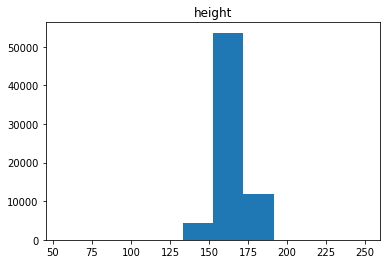

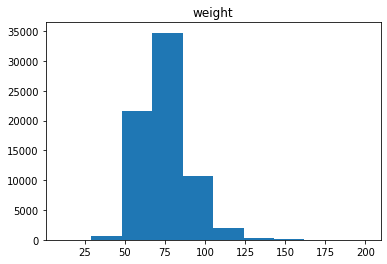

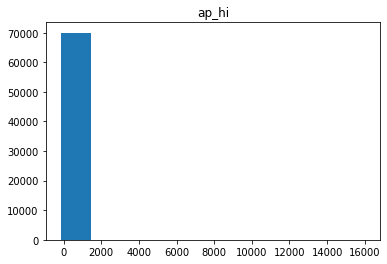

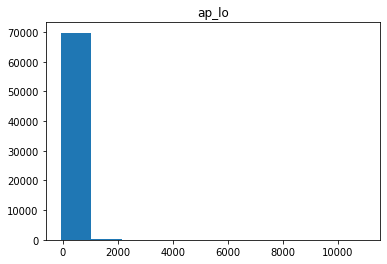

In [ ]:
for col in ['height', 'weight', 'ap_hi', 'ap_lo']:

  plt.hist(df[col])
  plt.title(col)
  plt.show()

### Оценка распределения бинарных признаков относительно целевой переменной

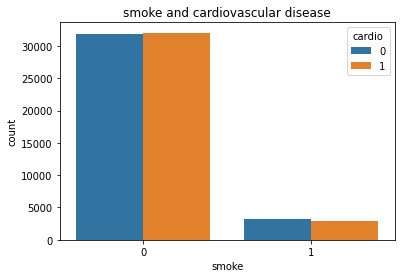

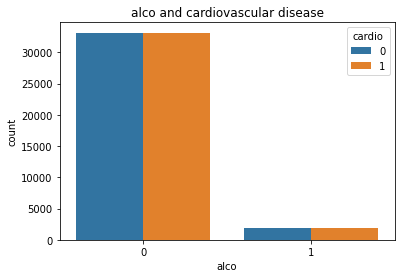

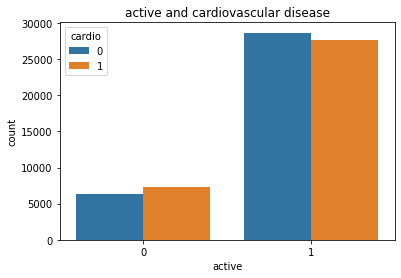

In [ ]:
for col in ['smoke', 'alco', 'active']:
  sns.countplot(x=col, hue='cardio', data=df)
  plt.title(f'{col} and cardiovascular disease')
  plt.show()

### Оценка распределения признака "Возраст" относительно целевой переменной

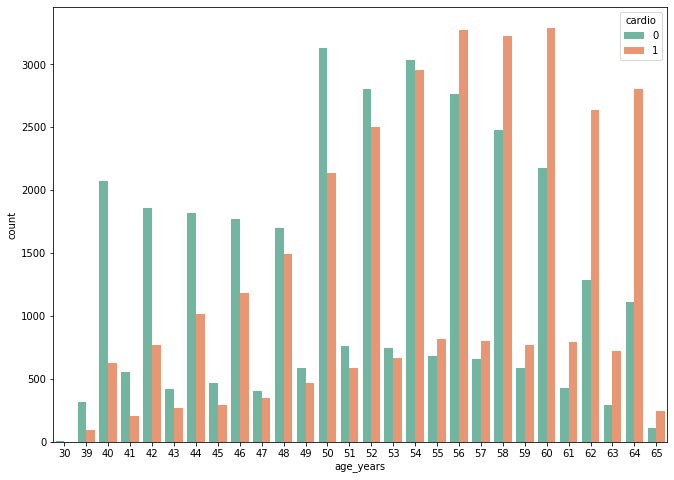

In [ ]:
rcParams['figure.figsize'] = 11, 8
sns.countplot(x='age_years', hue='cardio', data = df, palette="Set2");

### Оценка распределения категориальных признаков

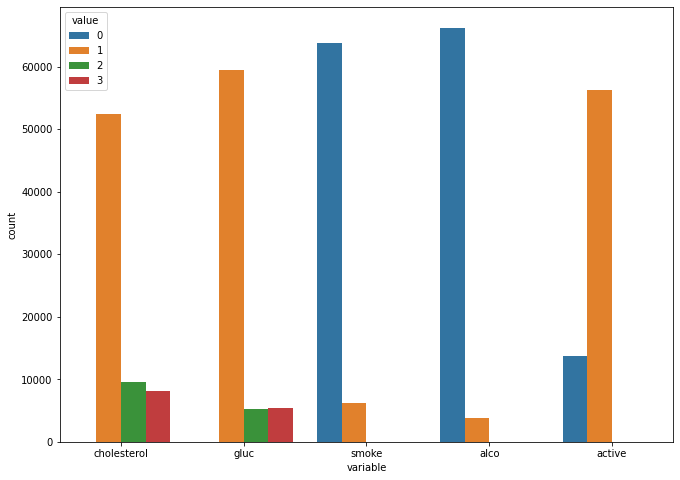

In [ ]:
df_categorical = df.loc[:,['cholesterol','gluc', 'smoke', 'alco', 'active']]
sns.countplot(x="variable", hue="value",data= pd.melt(df_categorical));

### Оценка распределения категориальных признаков относительно целевой переменной

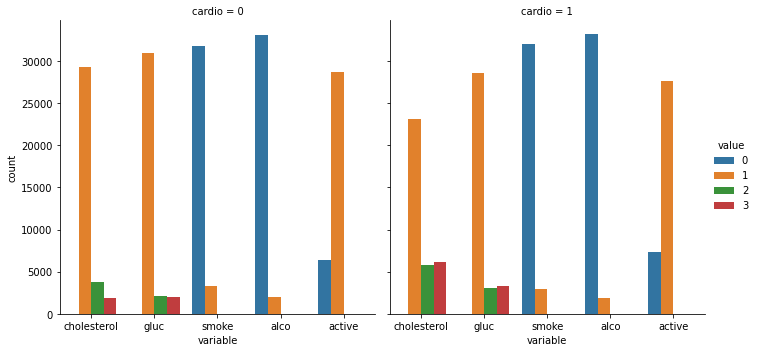

In [ ]:
df_long = pd.melt(df, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="cardio",
                data=df_long, kind="count");

In [ ]:
# gender 1 - man, 2 - woman

In [12]:
df.groupby('gender')['alco'].sum()

gender
1    1161
2    2603
Name: alco, dtype: int64

In [13]:
df['cardio'].value_counts(normalize=True)

0    0.5003
1    0.4997
Name: cardio, dtype: float64

In [ ]:
pd.crosstab(df['cardio'],df['gender'],normalize=True)

gender,1,2
cardio,,
0,0.327343,0.172957
1,0.323086,0.176614


In [ ]:
df['gluc'].value_counts()

1    59479
3     5331
2     5190
Name: gluc, dtype: int64

In [ ]:
df['cholesterol'].value_counts()

1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64

## Очистка данных

In [ ]:
df.loc[df['weight'] < 40, 'weight'].count()

52

In [ ]:
df.loc[df['weight'] > 170, 'weight'].count()

15

Выбросы по систолическому (верхнему) артериальному давлению (выше 220 и меньше 80)

In [ ]:
print(df.loc[df['ap_hi'] > 220, 'ap_hi'].count())
print(df.loc[df['ap_hi'] < 80, 'ap_hi'].count())

48
207


In [ ]:
df['ap_hi'].quantile([0.05, 0.25, 0.5, 0.75, 0.95])

0.05    100.0
0.25    120.0
0.50    120.0
0.75    140.0
0.95    160.0
Name: ap_hi, dtype: float64

Выбросы по диастолическому (нижнему) артериальному давлению (выше 110 и меньше 55)

In [ ]:
print(df.loc[df['ap_lo'] > 110, 'ap_lo'].count())
print(df.loc[df['ap_lo'] < 55, 'ap_lo'].count())

1282
142


In [ ]:
df['ap_lo'].quantile([0.05, 0.25, 0.5, 0.75, 0.95])

0.05     70.0
0.25     80.0
0.50     80.0
0.75     90.0
0.95    100.0
Name: ap_lo, dtype: float64

### Удаление выбросов

In [14]:
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)

In [15]:
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

Diastilic pressure is higher than systolic one in 1082 cases


In [16]:
df.drop(df[(df['ap_hi'] > 220) | (df['ap_hi'] < 80)].index,inplace=True)
df.drop(df[(df['ap_lo'] > 110) | (df['ap_lo'] < 55)].index,inplace=True)

## Создание новых признаков

### Пульсовое давление (разница между систолическим и диастолическим давлением)

In [17]:
df['pulse_pressure'] = round((df['ap_hi'] - df['ap_lo']) / df['ap_hi'], 2)

In [ ]:
df.loc[df['pulse_pressure'] < 0.25, 'pulse_pressure'].value_counts()

 0.20    368
 0.18    253
 0.23    183
 0.22    120
 0.10     44
 0.17     32
 0.21     28
 0.24     19
 0.11     12
 0.15     10
 0.19      5
 0.16      4
-0.38      4
 0.14      3
 0.12      3
 0.09      2
 0.08      2
 0.00      1
 0.06      1
-0.05      1
-0.11      1
-0.25      1
-0.31      1
Name: pulse_pressure, dtype: int64

In [18]:
df.drop(df[df['pulse_pressure'] < 0.25].index,inplace=True)

Diastilic pressure is higher than systolic one in 0 cases


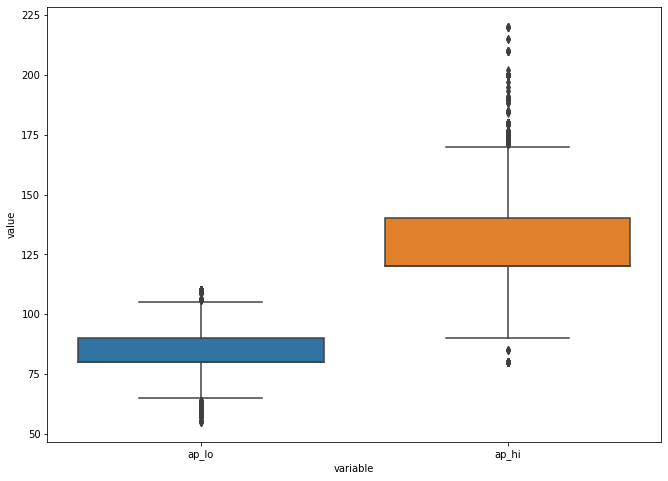

In [ ]:
blood_pressure = df.loc[:,['ap_lo','ap_hi']]
sns.boxplot(x = 'variable',y = 'value',data = blood_pressure.melt())
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

### Создание признака "Индекс массы тела" и отображение распределения относительно признака "Пол" и целевой переменной

$ИМТ=\dfrac M {P ^ 2}$  

М - масса тела, P – рост в метрах

Индекс массы тела | Соответствие между массой человека и его ростом  
16 и менее - Выраженный дефицит массы тела  
16—18,5 - Недостаточная (дефицит) масса тела  
18,5—25 - Норма  
25—30 - Избыточная масса тела (предожирение)  
30—35 - Ожирение 1 степени  
35—40 - Ожирение 2 степени  
40 и более - Ожирение 3 степени  

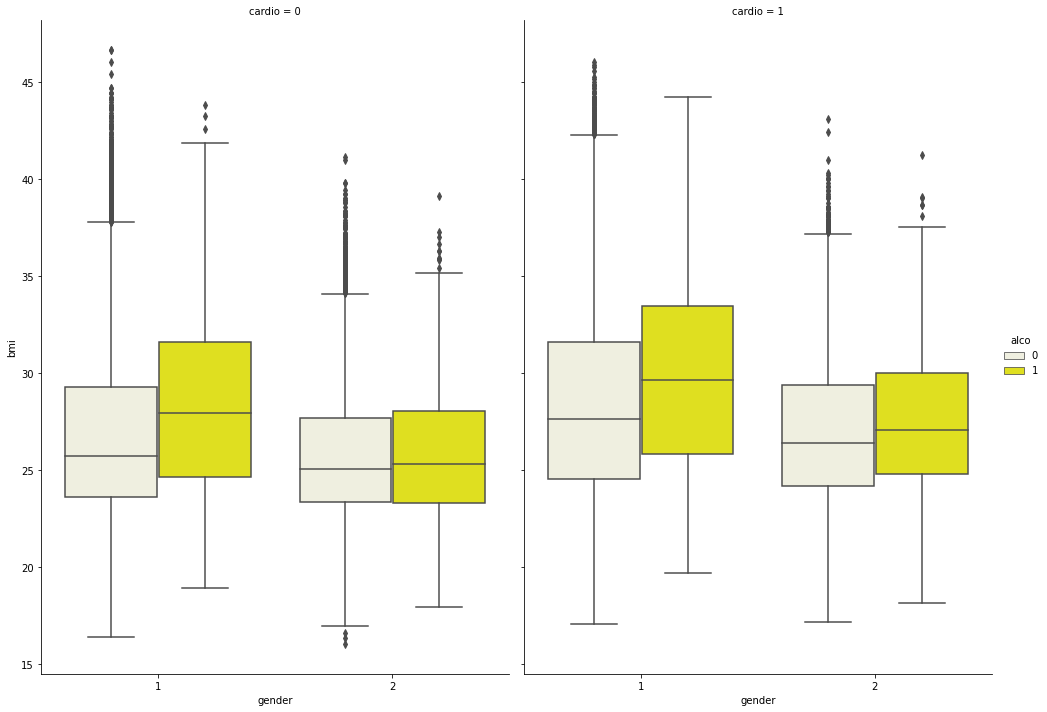

In [19]:
df['bmi'] = round(df['weight']/((df['height']/100)**2), 2)
sns.catplot(x="gender", y="bmi", hue="alco", col="cardio", data=df, color = "yellow",kind="box", height=10, aspect=.7);

### Матрица корреляции  признаков

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


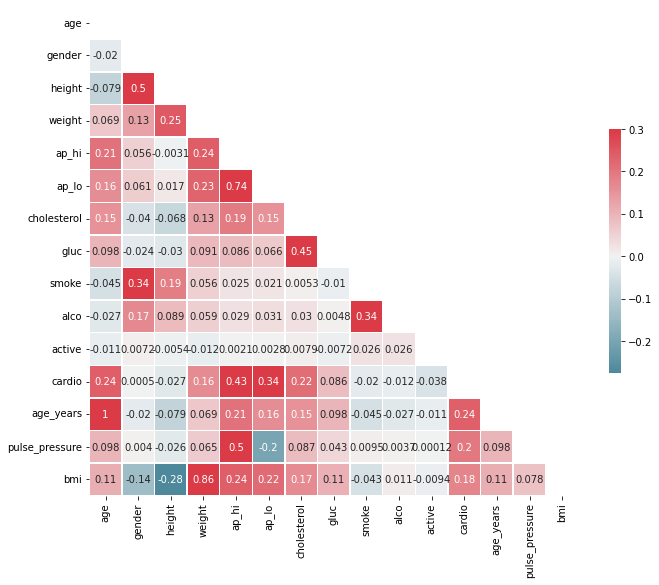

In [ ]:
corr = df.iloc[:, 1::] .corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

<!-- ИМТ = М / Р 2 (М – масса тела, P – рост в метрах). -->

## Разделение данных на тренировочную и тестовую выборки

In [20]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [21]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_years',
       'pulse_pressure', 'bmi'],
      dtype='object')

#### К полям: 
 - age, height, weight, ap_hi, ap_lo, pulse_pressure, bmi, cholesterol, gluc применим StandardScaler  
 - alco, active, smoke, genger применим бинарное OHE-кодирование


In [22]:
# Заполнение пропусков
class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X


class BMI(BaseEstimator, TransformerMixin):
    def __init__(self, height, weight):
        self.height = height
        self.weight = weight
        self.col = []

    def fit(self, X, y=None):
        self.col = 'bmi'
        return self

    def transform(self, X):
        X[self.col] = X[self.weight].values.reshape(-1,1) / ((X[self.height].values.reshape(-1,1) / 100) ** 2)
        # X_bmi = X[self.weight].values.reshape(-1,1) / ((X[self.height].values.reshape(-1,1) / 100) ** 2)
        # B = pd.DataFrame(data = X_bmi, index = X.index, columns = [self.col])
        return X[self.col].values.reshape(-1,1)


class PulsePressure(BaseEstimator, TransformerMixin):
    def __init__(self, ap_hi, ap_lo):
        self.ap_hi = ap_hi
        self.ap_lo = ap_lo
        self.col = []

    def fit(self, X, y=None):
        self.col = 'pulse_pressure'
        return self

    def transform(self, X):
        X[self.col] = (X[self.ap_hi].values.reshape(-1,1) - X[self.ap_lo].values.reshape(-1,1)) / X[self.ap_hi].values.reshape(-1,1) 
        # X_bmi = X[self.weight].values.reshape(-1,1) / ((X[self.height].values.reshape(-1,1) / 100) ** 2)
        # B = pd.DataFrame(data = X_bmi, index = X.index, columns = [self.col])
        return X[self.col].values.reshape(-1,1)


class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


class OHEEncoderBin(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        B = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        self.columns = B[:1]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        return X[self.columns]

### Отображение работы на отдельных признаках

In [23]:
gluc = Pipeline([
                ('imputer', TextImputer('gluc', '')),
                # ('selector', ColumnSelector(key='gluc')),
                ('selector', NumberSelector(key='gluc')),
                ('standard', StandardScaler())
                # ('ohe', OHEEncoder(key='gluc'))
])
gluc.fit(X_train)
gluc.transform(X_test)

array([[-0.39046915],
       [-0.39046915],
       [-0.39046915],
       ...,
       [-0.39046915],
       [-0.39046915],
       [-0.39046915]])

In [24]:
gender = Pipeline([
                ('selector', ColumnSelector(key='gender')),
                ('ohe', OHEEncoderBin(key='gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,gender_1
44974,1
22847,1
44214,0


In [25]:
age =  Pipeline([
                ('imputer', TextImputer('age_years', '')),
                ('selector', NumberSelector(key='age_years')),
                ('standard', StandardScaler())
            ])
age.fit(X_train)
age.transform(X_test)

array([[-0.64623891],
       [-0.34940647],
       [ 0.98633953],
       ...,
       [ 0.0958422 ],
       [ 0.24425842],
       [ 0.0958422 ]])

In [26]:
bmi =  Pipeline([
                ('bmi', BMI('height', 'weight')),
                ('standard', StandardScaler())
            ])
bmi.fit(df)
bmi.transform(X_test)

array([[-0.94677443],
       [ 0.23798069],
       [-0.10849628],
       ...,
       [-0.40874764],
       [ 0.11237346],
       [ 0.20817107]])

In [27]:
pulse_pressure =  Pipeline([
                ('pulse', BMI('ap_hi', 'ap_lo')),
                ('standard', StandardScaler())
            ])
pulse_pressure.fit(df)
pulse_pressure.transform(X_test)

array([[ 0.45521231],
       [ 0.72588954],
       [-0.68107961],
       ...,
       [ 0.45521231],
       [-0.68107961],
       [-2.58711968]])

In [28]:
continuos_cols = ['age_years', 'ap_hi', 'ap_lo', 'height'] # ['age_years', 'ap_hi', 'ap_lo', 'height', 'weight'] #
cat_cols = ['gluc', 'cholesterol']
base_cols = ['alco', 'active', 'smoke', 'gender']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('imputer', TextImputer(cont_col, 0)),
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('imputer', TextImputer(cat_col, 0)),
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('imputer', TextImputer(base_col, 0)),
                ('selector', NumberSelector(key=base_col)),
                ('one', OHEEncoderBin(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

bmi =  Pipeline([
                ('bmi', BMI('height', 'weight')),
                ('standard', StandardScaler())
            ])
continuos_transformers.append(('bmi', bmi))

pulse_pressure =  Pipeline([
                ('pulse', BMI('ap_hi', 'ap_lo')),
                ('standard', StandardScaler())
            ])
continuos_transformers.append(('pulse_pressure', pulse_pressure))

Объединение трансформеров с помощью FeatureUnion

In [29]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train).shape

(46012, 12)

##Загрузка алгоритма для ML-модели.
Алгоритм CatBoost основан на градиентном спуске и представляет собой мощный метод решения задач в машинном обучении с учителем. 

In [30]:
import random
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from catboost import CatBoostClassifier

In [31]:
random.seed(0)
models =  [xgb.XGBClassifier(), LogisticRegression(), CatBoostClassifier(verbose=0)]

## Обучение модели

In [32]:
preds = []
for model in models:
  pipeline = Pipeline([
    ('features',feats),
    ('classifier', model)
    ])
  pipeline.fit(X_train, y_train)
  preds.append(pipeline.predict_proba(X_test)[:, 1])

In [33]:
#наши прогнозы для тестовой выборки
preds

[array([0.23666084, 0.22761093, 0.82818973, ..., 0.31540444, 0.8132444 ,
        0.88169205], dtype=float32),
 array([0.29779044, 0.22679562, 0.80789038, ..., 0.36843081, 0.73661471,
        0.94701903]),
 array([0.20562957, 0.2116275 , 0.82815534, ..., 0.30473641, 0.79422008,
        0.85662498])]

Также необходимо перейти от вероятностей к меткам классов. Для этого нужно подобрать порог, после которого считается, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [34]:
result = {
    'model': [],
    'Best Threshold': [],
    'F-Score': [], 
    'Precision': [], 
    'Recall': []
}

In [35]:
fscore = []
ix = []
thresholds = []
for i in range(len(preds)):
  precision, recall, threshold = precision_recall_curve(y_test, preds[i])
  thresholds.append(threshold)
  fscore.append((2 * precision * recall) / (precision + recall))
  # locate the index of the largest f score
  ix.append(np.argmax(fscore[i]))
  print('Best params for ', models[i], ': Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[i][ix[i]], 
                                                                          fscore[i][ix[i]],
                                                                          precision[ix[i]],
                                                                          recall[ix[i]]))
  result['model'].append(models[i])
  result['Best Threshold'].append(thresholds[i][ix[i]])
  result['F-Score'].append(fscore[i][ix[i]])
  result['Precision'].append(precision[ix[i]])
  result['Recall'].append(recall[ix[i]])

Best params for  XGBClassifier() : Threshold=0.374503, F-Score=0.728, Precision=0.667, Recall=0.802
Best params for  LogisticRegression() : Threshold=0.401978, F-Score=0.723, Precision=0.660, Recall=0.798
Best params for  <catboost.core.CatBoostClassifier object at 0x7fe6390fec90> : Threshold=0.373082, F-Score=0.726, Precision=0.662, Recall=0.803


###Запись результатов

In [36]:
result = pd.DataFrame(data=result).sort_values('F-Score', ascending=False)
result

,model,Best Threshold,F-Score,Precision,Recall
0,XGBClassifier(),0.374503,0.727817,0.666520,0.801530
2,<catboost.core.CatBoostClassifier object at 0x...,0.373082,0.725777,0.662386,0.802585
1,LogisticRegression(),0.401978,0.722680,0.660373,0.797969


## Построение ROC-AUC кривой

In [37]:
def plot_roc_curve(y_test, y_score):
  sns.set(font_scale=1.5)
  sns.set_color_codes("muted")

  plt.figure(figsize=(10, 8))
  fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
  lw = 2
  plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
  plt.plot([0, 1], [0, 1])
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.savefig("ROC.png")
  plt.show()

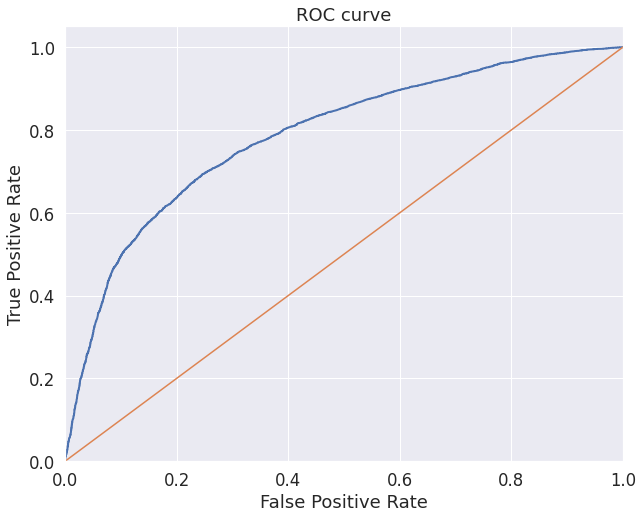

In [38]:
plot_roc_curve(y_test, preds[0])

In [39]:
from sklearn.metrics import roc_auc_score, log_loss
for i, m in enumerate(preds):
  roc_auc_scor = roc_auc_score(y_true=y_test, y_score=preds[i])
  print(models[i], ':')
  print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=preds[i])))
  print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=preds[i])))
  print('_________________________________________________________________')

XGBClassifier() :
roc auc score: 0.7866191920523979
log loss score: 0.5557087813068678
_________________________________________________________________
LogisticRegression() :
roc auc score: 0.7788357904311562
log loss score: 0.5714091736341599
_________________________________________________________________
<catboost.core.CatBoostClassifier object at 0x7fe6390fec90> :
roc auc score: 0.7828065985938719
log loss score: 0.5619079398813634
_________________________________________________________________


Так как 0,6 ≤ AUC < 0,8 — модель работает хорошо;

###Матрица ошибок

Confusion matrix, without normalization
[[4714 3041]
 [1506 6077]]


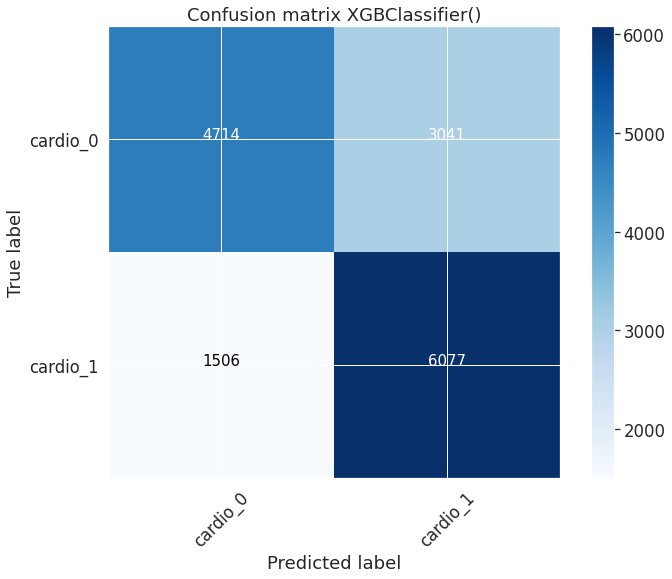

Confusion matrix, without normalization
[[4643 3112]
 [1533 6050]]


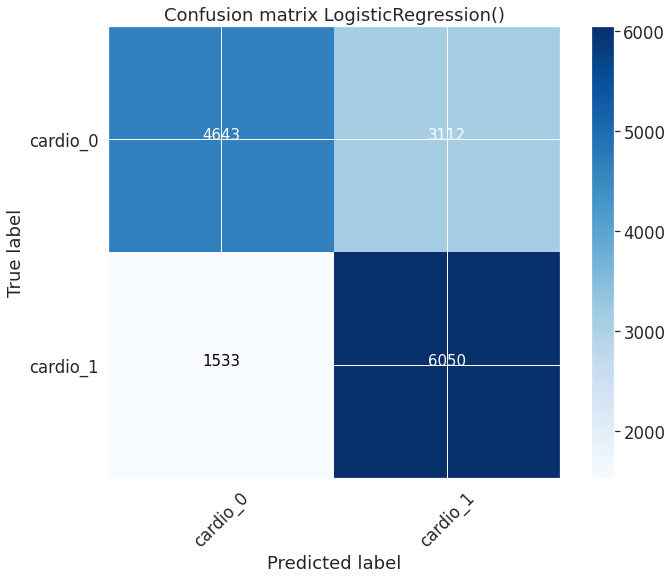

Confusion matrix, without normalization
[[4653 3102]
 [1498 6085]]


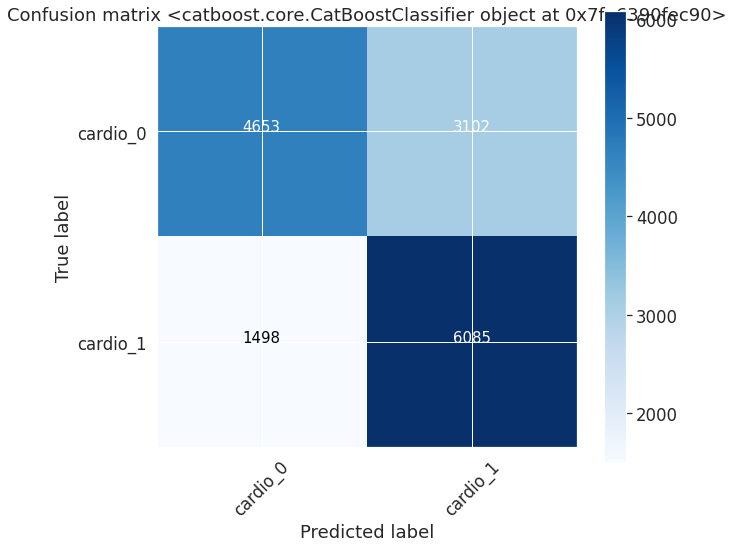

In [40]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

for i in range(len(preds)):
  cnf_matrix = confusion_matrix(y_test, preds[i]>thresholds[i][ix[i]])
  plt.figure(figsize=(10, 8))
  plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix ' + str(models[i]))
# plt.savefig("conf_matrix.png")
  plt.show()

# Обучение ФИНАЛЬНОЙ МОДЕЛИ 

In [41]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(verbose=0))
    ])
pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]

In [42]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.373082, F-Score=0.726, Precision=0.662, Recall=0.803


Recall рассчитывается как отношение числа Positive выборок
Recall=0.803 достаточно хорошо

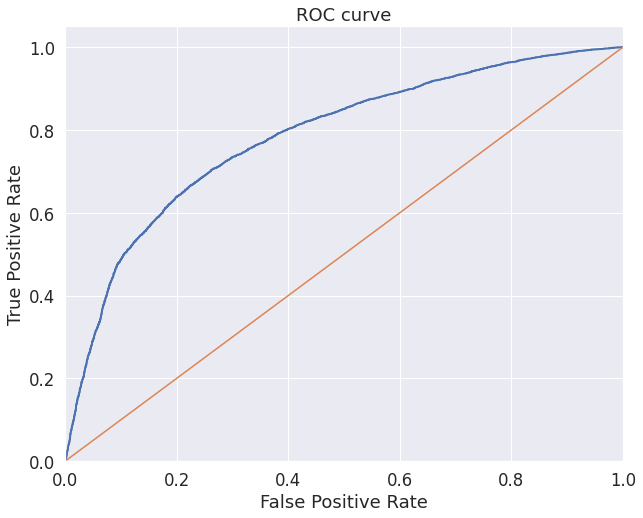

In [43]:
plot_roc_curve(y_test, preds)

Confusion matrix, without normalization
[[4653 3102]
 [1498 6085]]


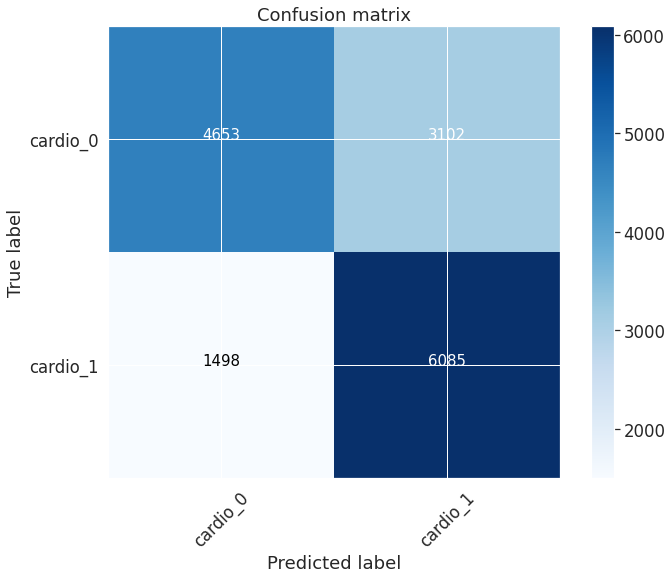

In [44]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
# pipeline.get_params()

###Процесс сериализации модели(перевода структуры данных в цепочку битов).
Необходим для сохранения либо передачи(например для развертывания)

In [45]:
with open("Catboost_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

In [46]:
import dill as pickle
with open("Catboost_pipeline.pkl", 'wb') as file:
    pickle.dump(pipeline, file) 

In [47]:
model = pickle.load(open('Catboost_pipeline.pkl', 'rb'))

In [48]:
x = pd.DataFrame({"age_years": [55, 66, 33], 
                                  'gender': [2, 2, 1], 
                                  'height': [180, 140, 170], 
                                  'weight': [110, 50, 80], 
                                  'ap_hi': [160, 120, 120], 
                                  'ap_lo': [120, 80, 80], 
                                  'cholesterol': [2, 2, 1], 
                                  'gluc': [1, 2, 3], 
                                  'smoke': [1, 1, 1], 
                                  'alco': [1, 1, 1],
                                  'active': [1, 1, 1] 
                        })
x

,age_years,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,55,2,180,110,160,120,2,1,1,1,1
1,66,2,140,50,120,80,2,2,1,1,1
2,33,1,170,80,120,80,1,3,1,1,1


In [49]:
model.predict_proba(x)

array([[0.25710021, 0.74289979],
       [0.68222768, 0.31777232],
       [0.86476431, 0.13523569]])